<h2 style="text-align:center;">ANN Practical Implementation — Churn Prediction</h2>

**Author:** Mubasshir Ahmed  
**Module:** Deep Learning — FSDS  
**Notebook:** 01_ANN_Implementation  
**Objective:** Implement an Artificial Neural Network on the `Churn_Modelling.csv` dataset. We'll apply theory: preprocessing, architecture design, activations, loss, and compare multiple optimizers (adam, sgd, rmsprop, adagrad, adadelta, adamax).  
**Notes:** This notebook includes clear inline comments (`# ➤`) and explanatory markdowns suitable for beginners and recruiters.


 <h3 style="text-align:center;">1. Imports & Environment Check</h3>


In [ ]:
# ➤ Import necessary libraries
import os                          # ➤ file operations
import time                        # ➤ to measure execution time
import numpy as np                 # ➤ numerical ops
import pandas as pd                # ➤ dataframes
import matplotlib.pyplot as plt    # ➤ plotting (one plot per cell)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

print("# ➤ Libraries loaded. TensorFlow version:", tf.__version__)


# ➤ Libraries loaded. TensorFlow version: 2.20.0


# <h3 style="text-align:center;">2. Check dataset presence</h3>


In [4]:
csv_path = r"C:\Users\MUBASSHIR\OneDrive\Desktop\FSDS_TASKS\Deep_Learning\02_Artificial_Neural_Network\07_ANN_Practical_Implementation\Churn_Modelling.csv"  # ➤ expected dataset path

if not os.path.exists(csv_path):
    print(f"# ➤ Dataset not found at {csv_path}")
    print("# ➤ Please upload 'Churn_Modelling.csv' into /mnt/data/ or adjust the path.")
else:
    df = pd.read_csv(csv_path)
    print(f"# ➤ Dataset found. Shape: {df.shape}")
    display(df.head(10))  # ➤ show sample rows


# ➤ Dataset found. Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


# <h3 style="text-align:center;">3. Quick EDA</h3>


In [5]:
# ➤ This cell runs only if 'df' is loaded
try:
    print('# ➤ Columns:', df.columns.tolist())
    print('# ➤ Missing values per column:')
    print(df.isnull().sum())
    print('\n# ➤ Target value counts (Exited):')
    print(df['Exited'].value_counts(normalize=True))
    display(df.describe().T)
except NameError:
    print('# ➤ df not defined. Please run the previous cell to load dataset.')


# ➤ Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
# ➤ Missing values per column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# ➤ Target value counts (Exited):
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


# <h3 style="text-align:center;">4. Data Preprocessing</h3>
``` ➤ Steps:```
> 1. Drop useless columns (RowNumber, CustomerId, Surname)
> 2. Encode categorical variables (Gender -> label, Geography -> one-hot)
> 3. Split into X and y and train-test split
> 4. Scale features

In [6]:


try:
    df_proc = df.copy()  # ➤ work on a copy
    df_proc.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)
    # ➤ Encode Gender
    le = LabelEncoder()
    df_proc['Gender'] = le.fit_transform(df_proc['Gender'])
    # ➤ One-hot encode Geography (drop one column to avoid dummy trap)
    geo_ohe = pd.get_dummies(df_proc['Geography'], prefix='Geo', drop_first=True)
    df_proc = pd.concat([df_proc.drop('Geography', axis=1), geo_ohe], axis=1)
    # ➤ Features and target
    X = df_proc.drop('Exited', axis=1)
    y = df_proc['Exited']
    # ➤ Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"# ➤ Shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}")
    # ➤ Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
except NameError:
    print('# ➤ df not defined. Please run the dataset-loading cell first.')


# ➤ Shapes -> X_train: (8000, 11), X_test: (2000, 11)


# <h3 style="text-align:center;">5. Model Builder</h3>
> ➤ Function to build a simple ANN model with given optimizer and activation choices

In [ ]:


def build_ann(input_dim, hidden_layers=[64,32], activation='relu', dropout_rate=0.3, optimizer='adam'):
    '''
    Returns a compiled Keras Sequential model.
    '''
    model = Sequential()
    # ➤ Input + first hidden layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout_rate))
    # ➤ Additional hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    # ➤ Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    # ➤ Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ➤ Quick test: do not run build here unless data is loaded
print('# ➤ Model builder ready.')


# ➤ Model builder ready.


# <h3 style="text-align:center;">6. Train & Compare Multiple Optimizers</h3>
> ➤ We'll train the same architecture with different optimizers and compare results.

In [13]:

import warnings
warnings.filterwarnings('ignore')
optimizers = ['adam','sgd','rmsprop','adagrad','adadelta','adamax']
results = []  # ➤ to store history and metrics

try:
    input_dim = X_train_scaled.shape[1]
    for opt in optimizers:
        print(f"# ➤ Training with optimizer: {opt}")
        tf.keras.backend.clear_session()
        model = build_ann(input_dim=input_dim, hidden_layers=[64,32], activation='relu', dropout_rate=0.3, optimizer=opt)
        # ➤ Early stopping to avoid long runs
        es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
        start = time.time()
        history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[es], verbose=0)
        end = time.time()
        # ➤ Evaluate on test set
        loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        # ➤ Predictions and metrics
        y_pred_prob = model.predict(X_test_scaled).ravel()
        y_pred = (y_pred_prob >= 0.5).astype(int)
        auc = roc_auc_score(y_test, y_pred_prob)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'optimizer': opt,
            'history': history.history,
            'test_loss': loss,
            'test_accuracy': acc,
            'roc_auc': auc,
            'confusion_matrix': cm,
            'classification_report': cr,
            'train_time_sec': end-start
        })
        print(f"# ➤ {opt} -> Test Acc: {acc:.4f}, AUC: {auc:.4f}, Time(s): {end-start:.1f}")
except NameError:
    print('# ➤ Preprocessed data not found. Run preprocessing cell first.')


# ➤ Training with optimizer: adam
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
# ➤ adam -> Test Acc: 0.8640, AUC: 0.8618, Time(s): 31.5
# ➤ Training with optimizer: sgd
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
# ➤ sgd -> Test Acc: 0.8580, AUC: 0.8586, Time(s): 57.7
# ➤ Training with optimizer: rmsprop
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# ➤ rmsprop -> Test Acc: 0.8610, AUC: 0.8559, Time(s): 21.2
# ➤ Training with optimizer: adagrad
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
# ➤ adagrad -> Test Acc: 0.8110, AUC: 0.7778, Time(s): 59.0
# ➤ Training with optimizer: adadelta
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
# ➤ adadelta -> Test Acc: 0.7965, AUC: 0.5118, Time(s): 61.5
# ➤ Training with optimizer: adamax
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
# ➤ adamax -> Test Acc: 0.8550, AUC: 0.8605, Time(s): 84.0


# <h3 style="text-align:center;">7. Results Summary</h3>
> ➤ Summarize optimizer comparison in a DataFrame and plot accuracy & AUC.

,optimizer,test_accuracy,roc_auc,test_loss,train_time_sec,epochs_trained
0,rmsprop,0.8620,0.857563,0.341324,30.190555,43
1,adamax,0.8615,0.860927,0.338694,51.402144,81
2,adam,0.8590,0.862234,0.338456,37.050680,47
3,sgd,0.8570,0.856541,0.344187,69.080826,100
4,adagrad,0.8140,0.794520,0.414801,69.493447,100
5,adadelta,0.7965,0.598781,0.510283,70.180491,100


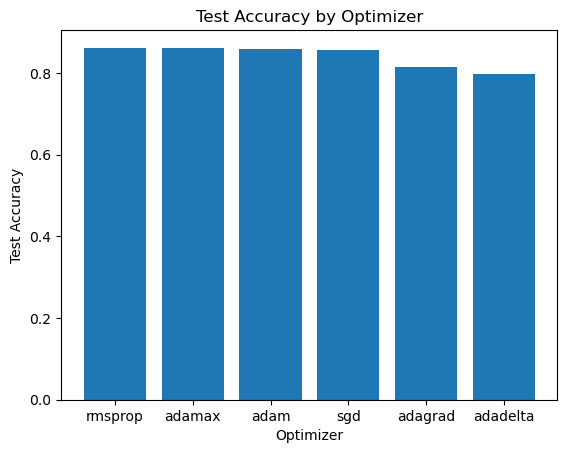

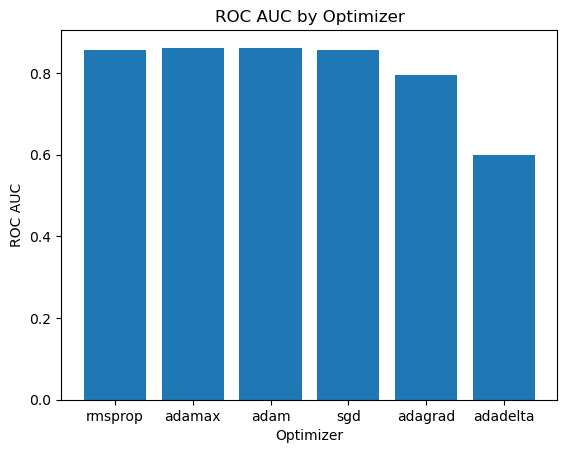

In [9]:
try:
    summary_rows = []
    for r in results:
        summary_rows.append({
            'optimizer': r['optimizer'],
            'test_accuracy': r['test_accuracy'],
            'roc_auc': r['roc_auc'],
            'test_loss': r['test_loss'],
            'train_time_sec': r['train_time_sec'],
            'epochs_trained': len(r['history']['loss'])
        })
    summary_df = pd.DataFrame(summary_rows).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
    display(summary_df)
    # ➤ Plot test accuracy bar chart
    plt.figure()
    plt.bar(summary_df['optimizer'], summary_df['test_accuracy'])
    plt.title('Test Accuracy by Optimizer')
    plt.xlabel('Optimizer')
    plt.ylabel('Test Accuracy')
    plt.show()
    # ➤ Plot ROC AUC bar chart
    plt.figure()
    plt.bar(summary_df['optimizer'], summary_df['roc_auc'])
    plt.title('ROC AUC by Optimizer')
    plt.xlabel('Optimizer')
    plt.ylabel('ROC AUC')
    plt.show()
except NameError:
    print('# ➤ No results to summarize. Run the training cell first.')


# <h3 style="text-align:center;">8. Training Curves (Example)</h3>
> ➤ Plot training/validation loss & accuracy for the first optimizer as example.

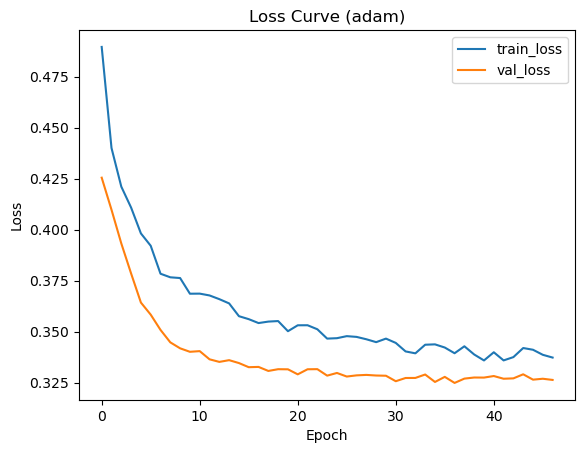

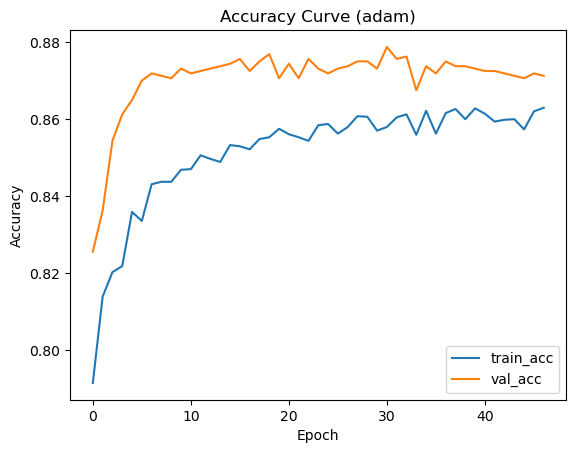

In [10]:


try:
    if len(results) > 0:
        r = results[0]  # ➤ example: first optimizer
        history = r['history']
        # ➤ Loss curve
        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title(f"Loss Curve ({r['optimizer']})")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['train_loss','val_loss'])
        plt.show()
        # ➤ Accuracy curve
        plt.figure()
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(f"Accuracy Curve ({r['optimizer']})")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['train_acc','val_acc'])
        plt.show()
    else:
        print('# ➤ No training history found.')
except NameError:
    print('# ➤ results not defined. Run training cell first.')


# <h3 style="text-align:center;">9. Confusion Matrix & Classification Report (Example)</h3>
> ➤ Show confusion matrix and classification report for the best optimizer (highest test_accuracy)

In [11]:


try:
    summary_df  # check exists
    best_opt = summary_df.iloc[0]['optimizer']
    best_res = next((r for r in results if r['optimizer']==best_opt), None)
    print(f"# ➤ Best optimizer: {best_opt}")
    print("# ➤ Confusion Matrix:")
    print(best_res['confusion_matrix'])
    print("\n# ➤ Classification Report:")
    print(pd.DataFrame(best_res['classification_report']).T)
except Exception as e:
    print('# ➤ Could not display confusion matrix — ensure training was executed.', e)


# ➤ Best optimizer: rmsprop
# ➤ Confusion Matrix:
[[1550   43]
 [ 233  174]]

# ➤ Classification Report:
              precision    recall  f1-score   support
0              0.869321  0.973007  0.918246  1593.000
1              0.801843  0.427518  0.557692   407.000
accuracy       0.862000  0.862000  0.862000     0.862
macro avg      0.835582  0.700263  0.737969  2000.000
weighted avg   0.855590  0.862000  0.844874  2000.000


# <h3 style="text-align:center;">10. Model Summary & Closing Notes</h3>
> ➤ Display the architecture of the last trained model (if exists) and final notes

In [12]:


try:
    model  # last trained model variable
    print('# ➤ Model summary:')
    model.summary()  # ➤ prints layers and parameter counts
    print('\n# ➤ Notes:')
    print('- The notebook compares multiple optimizers using same architecture.')
    print('- You can change hidden_layers, activation, dropout_rate in build_ann().')
    print('- For final deployment, consider saving the best model using model.save().')
except NameError:
    print('# ➤ No trained model in memory. Run the training cell first.')


# ➤ Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,645 (33.77 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,764 (22.52 KB)


# ➤ Notes:
- The notebook compares multiple optimizers using same architecture.
- You can change hidden_layers, activation, dropout_rate in build_ann().
- For final deployment, consider saving the best model using model.save().
